# rqalpha

## Install 
`pip install -i https://pypi.douban.com/simple rqalpha`

## Download Bundle:

`rqalpha download-bundle`

In [3]:
!rqalpha download-bundle

try http://bundle.assets.ricequant.com/bundles_v4/rqbundle_202104.tar.bz2 ...
downloading ...  [####################################]  100%          
Data bundle download successfully in /Users/winshare/.rqalpha/bundle


## Config Generate

In [4]:
!rqalpha generate-config

Config file has been generated in /Users/winshare/workspace/Business/config.yml


In [15]:
import os 
import yaml
config=open("/Users/winshare/workspace/Business/config.yml","r",encoding="utf-8")
config_data = yaml.load(config)
for k,v in config_data.items():
    if type(v) is dict:
        print("|-",k)
        for kk,vv in v.items():
            print("    |-",kk,":",vv)
    else:
        print("|-",k,":",v)
            

|- version : 0.1.6
|- whitelist : ['base', 'extra', 'validator', 'mod']
|- base
    |- data_bundle_path : /Users/winshare/.rqalpha/bundle
    |- strategy_file : strategy.py
    |- source_code : None
    |- start_date : 2015-06-01
    |- end_date : 2050-01-01
    |- margin_multiplier : 1
    |- run_type : b
    |- frequency : 1d
    |- persist : False
    |- persist_mode : real_time
    |- accounts : {'stock': None, 'future': None}
    |- market : cn
    |- init_positions : {}
    |- round_price : False
    |- future_info : {}
    |- forced_liquidation : True
|- extra
    |- log_level : info
    |- context_vars : None
    |- enable_profiler : False
    |- is_hold : False
    |- locale : zh_Hans_CN
    |- logger : []


/Users/winshare/anaconda3/envs/workspace/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


# strategy Design

In [24]:
# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    logger.info("init")
    context.s1 = "000001.XSHE"
    update_universe(context.s1)
    # 是否已发送了order
    context.fired = False
    context.cnt = 1


def before_trading(context):
    logger.info("Before Trading", context.cnt)
    context.cnt += 1


# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    context.cnt += 1
    logger.info("handle_bar", context.cnt)
    # 开始编写你的主要的算法逻辑

    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合状态信息

    # 使用order_shares(id_or_ins, amount)方法进行落单

    # TODO: 开始编写你的算法吧！
    if not context.fired:
        # order_percent并且传入1代表买入该股票并且使其占有投资组合的100%
        order_percent(context.s1, 1)
        context.fired = True

# Back Test

In [25]:
from rqalpha.api import *
from rqalpha import run_func

[2021-04-13 03:05:53.648377] DEBUG: system_log: 
{'base': {'accounts': {'STOCK': 100000.0},
          'benchmark': '000300.XSHG',
          'data_bundle_path': '/Users/winshare/.rqalpha/bundle',
          'end_date': datetime.date(2016, 12, 1),
          'forced_liquidation': True,
          'frequency': '1d',
          'future_info': {},
          'init_positions': [],
          'margin_multiplier': 1,
          'market': MARKET.CN,
          'persist': False,
          'persist_mode': PERSIST_MODE.REAL_TIME,
          'round_price': False,
          'run_type': RUN_TYPE.BACKTEST,
          'source_code': None,
          'start_date': datetime.date(2016, 6, 1),
          'strategy_file': 'strategy.py'},
 'extra': {'context_vars': None,
           'enable_profiler': False,
           'is_hold': False,
           'locale': 'zh_Hans_CN',
           'log_level': 'verbose',
           'logger': []},
 'mod': {'sys_accounts': {'enabled': True},
         'sys_analyser': {'enabled': True, 'plo

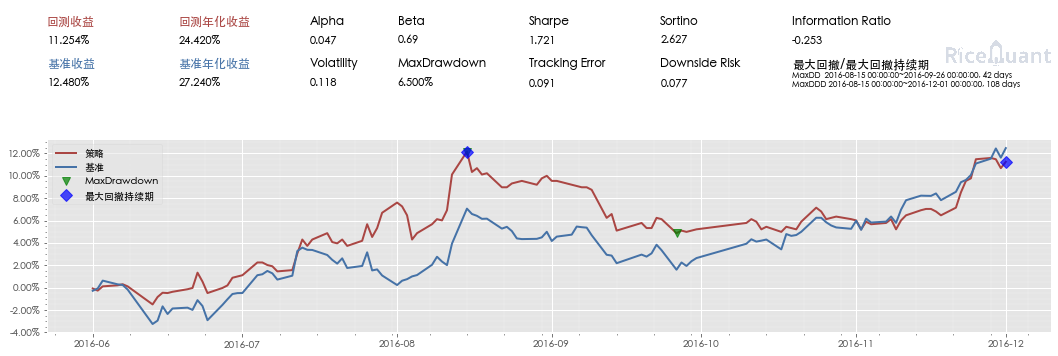

[2021-04-13 03:05:56.339608] DEBUG: system_log: mod tear_down [END]   sys_analyser
[2021-04-13 03:05:56.343016] DEBUG: system_log: mod tear_down [START] sys_risk
[2021-04-13 03:05:56.343633] DEBUG: system_log: mod tear_down [END]   sys_risk
[2021-04-13 03:05:56.344065] DEBUG: system_log: mod tear_down [START] sys_progress
[2021-04-13 03:05:56.344576] DEBUG: system_log: mod tear_down [END]   sys_progress
[2021-04-13 03:05:56.345136] DEBUG: system_log: mod tear_down [START] sys_simulation
[2021-04-13 03:05:56.345567] DEBUG: system_log: mod tear_down [END]   sys_simulation
[2021-04-13 03:05:56.346019] DEBUG: system_log: mod tear_down [START] sys_accounts
[2021-04-13 03:05:56.346630] DEBUG: system_log: mod tear_down [END]   sys_accounts
[2021-04-13 03:05:56.347116] DEBUG: system_log: 策略运行成功，正常退出


{'sys_analyser': {'summary': {'strategy_name': 'strategy',
   'start_date': '2016-06-01',
   'end_date': '2016-12-01',
   'strategy_file': 'strategy.py',
   'run_type': 'BACKTEST',
   'STOCK': 100000.0,
   'alpha': 0.047,
   'beta': 0.69,
   'sharpe': 1.721,
   'information_ratio': -0.253,
   'downside_risk': 0.077,
   'tracking_error': 0.091,
   'sortino': 2.627,
   'volatility': 0.118,
   'max_drawdown': 0.065,
   'total_value': 111253.852,
   'cash': 1813.852,
   'total_returns': 0.112539,
   'annualized_returns': 0.2442,
   'unit_net_value': 1.1125,
   'units': 100000.0,
   'benchmark_total_returns': 0.1248,
   'benchmark_annualized_returns': 0.2724},
  'trades':                         trading_datetime order_book_id symbol side  \
  datetime                                                             
  2016-06-01 15:00:00  2016-06-01 15:00:00   000001.XSHE   平安银行  BUY   
  
                      position_effect         exec_id  tax  commission  \
  datetime                       

In [28]:
config = {
  "base": {
    "start_date": "2016-06-01",
    "end_date": "2016-12-01",
    "benchmark": "000300.XSHG",
    "accounts": {
        "stock": 100000
    }
  },
  "extra": {
    "log_level": "verbose",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}
run_func(init=init, 
         before_trading=before_trading, 
         handle_bar=handle_bar, 
         config=config
        )
